## JORDAN'S SCRATCH WORK FOR SENSITIVITY ANALYSIS BINN Evaluation of Learned Parameters
#### Uses BINNCovasim Neural Network Model

In [27]:
import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import BINNCovasim
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Loaders.DataFormatter as DF
#from utils import get_case_name #, AIC_OLS, RSS
import numpy as np

from scipy import integrate
from scipy import sparse
from scipy import interpolate
from scipy.stats import beta
import os
import scipy.io as sio
import scipy.optimize
import itertools
import time

import pdb

from Modules.Models.BuildBINNs import chi as chi_func_arr
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
lasso_ODE = PDESolver.lasso_ODE

from Modules.Utils.DRUMS_Lasso import DRUMS_Lasso
from utils import get_case_name, lasso_parameter_fitting
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp 
import warnings
warnings.filterwarnings("ignore", message="Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions")




In [28]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [29]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
# path = '../Data/covasim_data/xin_data/'

# population = int(200e3)
# test_prob = 0.1
# trace_prob = 0.3
# keep_d = True
# retrain = False
# dynamic = True
# masking = 0
# multiple = True
# parallelb = True
# n_runs = 1024
# chi_type = 'piecewise'


population = int(200e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 0
multiple = False
parallelb = False
n_runs = 1024
chi_type = 'piecewise'


from utils import get_case_name
case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)
# yita_lb, yita_ub = 0.2, 0.4

In [30]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingthresh'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [31]:
# split into train/val and convert to torch
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()

params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)[:,None]

tracing_array = params['tracing_array']

In [32]:

#mydir = '../models/covasim/2023-07-06_23-47-16' # no masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 50e3 epochs, lr=1e4

mydir = '../models/covasim/2023-07-12_11-00-45' # no masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 50e3 epochs, lr=1e4

In [33]:
# instantiate BINN model
binn = BINNCovasim(params, t_max, tracing_array, keep_d=keep_d).to(device)
parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [34]:
# load model weights. if retrain==True then load the retrained model
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)

# grab initial condition
u0 = data[0, :].copy()

In [35]:
# learned surface fitter
def surface_fitter(t):
    res = binn.surface_fitter(t)
    return res

# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u)) # [:,[0,3,4]]
    return to_numpy(res)

# learned effective tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)

# learned diagnosis of quarantined rate function
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

# do regression to figure out contact rate
def contact_rate_regression(u):
    s, a, y = u[:, 0][:, None], u[:, 1][:, None], u[:, 2][:, None]
    features = [np.ones_like(a), s, s**2, a, y] #
    features = np.concatenate(features, axis=1)
    res = features @ regression_coefs_cr
    # res *= 1.4
    return res

# do regression to figure out tracing rate
def beta_regression(u):
    a, b = u[:, 0][:, None], u[:, 1][:, None]
    features = [np.ones_like(a), a, b] #
    features = np.concatenate(features, axis=1)
    res = features @ regression_coefs_qt
    return res

# do regression to figure out diagnoses rate (on quarantined folks)
def tau_regression(u):
    a, b = u[:, 0][:, None], u[:, 1][:, None]
    features = [np.ones_like(a), a, b] #
    features = np.concatenate(features, axis=1)
    res = features @ regression_coefs_tau
    return res


In [36]:
# simulate PDE. First grab the parameter values from the loaded BINN model.
params['yita_lb'] = model.model.yita_lb
params['yita_ub'] = model.model.yita_ub
params['beta_lb'] = model.model.beta_lb
params['beta_ub'] = model.model.beta_ub
params['tau_lb'] = model.model.tau_lb
params['tau_ub'] = model.model.tau_ub

In [37]:
s_min, s_max = data[:,0].min(), data[:,0].max()
a_min, a_max = data[:,3].min(), data[:,3].max()
y_min, y_max = data[:,4].min(), data[:,4].max()
say_min, say_max = (data[:,0] + data[:,3] + data[:,4]).min(), (data[:,0] + data[:,3] + data[:,4]).max()
chi_min, chi_max = 0.0, params['eff_ub']
yita_lb, yita_ub = model.model.yita_lb, model.model.yita_ub
beta_lb, beta_ub = model.model.beta_lb, model.model.beta_ub
tau_lb, tau_ub = model.model.tau_lb, model.model.tau_ub

In [38]:
from scipy.stats import beta as bt

def chi_func(t, chi_type):
    eff_ub = 0.3
    if chi_type == 'linear':
        rate = eff_ub / 75
        if t < 75:
            factor = rate * (t + 1)
        elif 75 <= t < 150:
            factor = eff_ub - rate * (t - 75 + 1)
        else:
            factor = 0
        # factor = torch.where(t < 30.0, rate * t, eff_ub * torch.ones_like(t))
    elif chi_type == 'sin':
        rad_times = t * np.pi / 40.
        factor = 0.3 * (1 + np.sin(rad_times)) / 2
    elif chi_type == 'piecewise':
        a, b = 3, 3
        t_max = 159
        max_val = bt.pdf(0.5, a, b, loc=0, scale=1)
        if t < 80:
            factor = bt.pdf(t / t_max, a, b, loc=0, scale=1) * eff_ub / max_val
        elif t >= 120:
            factor = bt.pdf((t - 40) / t_max, a, b, loc=0, scale=1) * eff_ub / max_val
        else:
            factor = eff_ub
    elif chi_type == 'constant':
        factor = eff_ub
    return factor


In [39]:
chi_array = np.array([])
for item in t:
    chi_array = np.append(chi_array, chi_func(item, "piecewise"))


In [40]:
s_grid = np.linspace(s_min, s_max, 10)
a_grid = np.linspace(a_min, a_max, 10)
y_grid = np.linspace(y_min, y_max, 10)



In [41]:
#Eta -------------------------
train_x1 = np.array(np.meshgrid(s_grid, a_grid, y_grid)).T.reshape(-1,3)

data_y1 = contact_rate(data[:,[0,3,4]])
data_y1 = data_y1[:,0][:, None]

eta_rhs_values = {
    'S' : data[:,0],
    'A' : data[:,3],
    'Y' : data[:,4],
}

results_eta = DRUMS_Lasso(input_dict = eta_rhs_values, lhs_values = data_y1, alphas = np.array([0])) 

print()
print()
print("Equation for Eta: " + str(results_eta['Equation']))
print("Eta MSE: " + str(results_eta["MSE"]))
print()
print()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000192560116225279, tolerance: 0.00018150869659086104
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019747754636237607, tolerance: 0.00018150869659086104
  model = cd_fast.ene

In [99]:
#Beta--------------------------


say_grid = np.linspace(say_min, say_max, 10)

chi_grid = np.linspace(chi_min, chi_max, 10)

# Create meshgrid from the 1D arrays
SAY, XX = np.meshgrid(say_grid, chi_grid)   #SAY is the sum S + A + Y

# Reshape and combine the arrays
data_x2 = np.column_stack((SAY.ravel(), XX.ravel()))
data_y2 = beta(data_x2)


say_sum = np.add(data[:,0], data[:,3])
say_sum = np.add(say_sum, data[:,4])


data_beta = beta(np.concatenate([say_sum[:, None], chi_array[:, None]], axis = 1))





beta_rhs_values = {
    'SAY' : data_x2[:,0],
    'X' : data_x2[:,1]
}



results_beta = DRUMS_Lasso(input_dict = beta_rhs_values, lhs_values = data_y2, alphas=np.array([0])) 

print()
print()
print(results_beta["Lasso"].intercept_)
print(results_beta["Lasso"].coef_)
print("Equation for Beta: " + str(results_beta['Equation']))
print("Beta MSE: " + str(results_beta["MSE"]))
print()
print()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e-04, tolerance: 1.211e-04
  model = cd_fast.enet_coordinate_descent(


In [43]:
#Tau-------------------------------




labels = ['A', 'Y']

AA, YY = np.meshgrid(a_grid, y_grid)
data_x3 = np.column_stack((AA.ravel(), YY.ravel()))
data_tau = tau(data_x3)

data_tau = tau_lb + (tau_ub - tau_lb) * data_tau # scaling
data_tau = np.round(data_tau, decimals=4)

tau_rhs_values = {
    'A' : data_x3[:,0],
    'Y' : data_x3[:,1],
}
results_tau = DRUMS_Lasso(input_dict = tau_rhs_values, lhs_values = data_tau, alphas = np.array([0]))

print()
print()
print("Equation for Tau: " + str(results_tau['Equation']))
print("Tau MSE: " + str(results_tau["MSE"]))
print()
print()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_r

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Equation for Tau: F + 0.1007
Tau MSE: 0.0




/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/

In [141]:
def lasso_ODE_test(t, y, tup : tuple, params : dict, t_max, chi_type):
# def lasso_ODE_test(t, y, *args):

    '''
    t (float)           : initial time  **check me, should this be initial time or tuple of time?
    y (list)            : list of initial conditions (floats) for STEAYDQRF
    tup (tuple)         : tuple of lasso objects for eta beta and tau, or tuple of complex coefficients
    params (dict)       : parameters of the Covasim model from the learned MLP
    t_max (float)       : max of time (last day of simulation)  **check me, if time is a tuple, do I need this?
    chi_type
    '''



    population = params['population']
    alpha = params['alpha']
    gamma = params['gamma']
    mu = params['mu']
    lamda = params['lamda']
    p_asymp = params['p_asymp']
    n_contacts = params['n_contacts']
    delta = params['delta']
    eff_ub = params['eff_ub']
    chi = chi_func(t, chi_type)

    

    # evaluate the constant value of each parameter
    S, T, E, A, Y, D, Q, R, F = tuple(y)   #values at this specific time

    # this is checking to see if we are doing complex or not

    if isinstance(tup[0], LassoCV): #not complex
        eta_lasso, beta_lasso, tau_lasso = tup #tuple of lasso objects

        #_____________________________________________________________________
        #   eta
        eta_poly = PolynomialFeatures(degree = 2, include_bias = True)
        eta_input = eta_poly.fit_transform(np.array([[S, A, Y]]))
        eta_input = eta_input[:,1:]

        #if using predict: 
        #eta_i = eta_lasso.predict(eta_input)    #eta value at this specific time

        #if using dot products instead of predict:
        eta_input = np.squeeze(eta_input)
        eta_co = eta_lasso.coef_
        eta_i = np.dot(eta_input, eta_co) + eta_lasso.intercept_
   
        #_____________________________________________________________________
        #   beta

        beta_poly = PolynomialFeatures(degree = 2, include_bias = True)
        beta_input = beta_poly.fit_transform([[S+A+Y, chi]])
        beta_input = beta_input[:,1:]

        #if using predict: 
        #beta_i = beta_lasso.predict(beta_input)

        #if using dot products instead of predict:
        beta_input = np.squeeze(beta_input)
        beta_co = beta_lasso.coef_
        beta_i = np.dot(beta_input, beta_co) + beta_lasso.intercept_
        #_____________________________________________________________________
        #   tau

        tau_poly = PolynomialFeatures(degree = 2, include_bias = True)
        tau_input = tau_poly.fit_transform([[A, Y]])
        tau_input = tau_input[:,1:]

        #if using predict: 
        #tau_i = tau_lasso.predict(tau_input)

        #if using dot products instead of predict:
        tau_input = np.squeeze(tau_input)
        tau_co = tau_lasso.coef_
        tau_i = np.dot(tau_input, tau_co) + tau_lasso.intercept_

        #__________________________________________________________________

        new_d = mu * Y +  tau_i * Q

        dS = - eta_i * S * (A + Y) -  beta_i * new_d *  n_contacts * S +  alpha * T

        dT = beta_i * new_d *  n_contacts * S -  alpha * T

        dE = eta_i * S * (A + Y) -  gamma * E

        dA =  p_asymp *  gamma * E -  lamda * A -  beta_i * new_d *  n_contacts * A

        dY = (1 -  p_asymp) *  gamma * E - ( mu +  lamda +  delta) * Y -  beta_i * new_d *  n_contacts * Y

        dD =  mu * Y + tau_i * Q - lamda * D - delta * D

        dQ =  beta_i * new_d *  n_contacts * (A + Y) - (tau_i + delta) * Q

        dR =  lamda * (A + Y + D)

        dF =  delta * (Y + D + Q)


        result = [float(dS), float(dT), float(dE), float(dA), float(dY), float(dD), float(dQ), float(dR), float(dF)]
        return result






    else:   #using manual coefficients instead of lasso objects because they're complex
              
        eta_coefs, beta_coefs, tau_coefs = tup
        S = float(S)
        T = float(T)
        E = float(E)
        A = float(A)
        Y = float(Y)
        D = float(D)
        Q = float(Q)
        R = float(R)
        F = float(F)
          
        #_____________________________________________________________________
        #   eta

        eta_poly = PolynomialFeatures(degree = 2, include_bias = True)

        eta_input = eta_poly.fit_transform(np.array([[S, A, Y]]))
        eta_input = eta_input[:,1:]
        #if using predict: 
        #eta_i = eta_lasso.predict(eta_input)    #eta value at this specific time

        #if using dot products instead of predict:
        eta_input = np.squeeze(eta_input)
        eta_co = eta_coefs[:-1]
        eta_i = np.dot(eta_input, eta_co) + eta_coefs[-1]
        eta_i = eta_i + 0j
       

        #_____________________________________________________________________
        #   beta

        beta_poly = PolynomialFeatures(degree = 2, include_bias = True)
        beta_input = beta_poly.fit_transform([[S+A+Y, chi]])
        beta_input = beta_input[:,1:]

        #if using predict: 
        #beta_i = beta_lasso.predict(beta_input)

        #if using dot products instead of predict:
        beta_input = np.squeeze(beta_input)
        beta_co = beta_coefs[:-1]
        beta_i = np.dot(beta_input, beta_co) + beta_coefs[-1]
        beta_i = beta_i + 0j

        #_____________________________________________________________________
        #   tau
        
        tau_poly = PolynomialFeatures(degree = 2, include_bias = True)
        tau_input = tau_poly.fit_transform([[A, Y]])
        tau_input = tau_input[:,1:]

        #if using predict: 
        #tau_i = tau_lasso.predict(tau_input)

        #if using dot products instead of predict:
        tau_input = np.squeeze(tau_input)
        tau_co = tau_coefs[:-1]
        tau_i = np.dot(tau_input, tau_co) + tau_coefs[-1]
        tau_i =tau_i + 0j
        #_____________________________________________________________________
    

        new_d = mu * Y +  tau_i * Q




        dS = - eta_i * S * (A + Y) -  beta_i * new_d *  n_contacts * S +  alpha * T

        dT = beta_i * new_d *  n_contacts * S -  alpha * T

        dE = eta_i * S * (A + Y) -  gamma * E

        dA =  p_asymp *  gamma * E -  lamda * A -  beta_i * new_d *  n_contacts * A

        dY = (1 -  p_asymp) *  gamma * E - ( mu +  lamda +  delta) * Y -  beta_i * new_d *  n_contacts * Y

        dD =  mu * Y + tau_i * Q - lamda * D - delta * D

        dQ =  beta_i * new_d *  n_contacts * (A + Y) - (tau_i + delta) * Q

        dR =  complex(lamda * (A + Y + D), 0)

        dF =  complex(delta * (Y + D + Q), 0)


    
        result = [dS, dT, dE, dA, dY, dD, dQ, dR, dF]
  

        return result



In [118]:
def STEAYDQRF_RHS_dynamic(t, y, contact_rate, quarantine_test, tau_func, params, t_max, chi_type):
    '''
    RHS evaluation of learned components for the STEAYDQRF model.
    
    Args:
        t (array): time vector.
        y (array): vector of values of STEAYDQRF.
        contact_rate (func): the contact rate learned MLP in the BINN model.
        quarantine_test (func): the quarantining rate learned MLP in the BINN model.
        tau_func (func): the quarantine diagnoses rate learned MLP in the BINN model.
        params (dict): paramters of COVASIM model.
        t_max (float): the maximum value of time in the t array.
        chi_type (str): string indicated the type of function chi is.
    
    Returns:
        (array): numpy array of values of each differential term in the ODE system.
    '''

    population = params['population']
    alpha = params['alpha']
    gamma = params['gamma']
    mu = params['mu']
    lamda = params['lamda']
    p_asymp = params['p_asymp']
    n_contacts = params['n_contacts']
    delta = params['delta']

   

    eff_ub = params['eff_ub']
    chi = chi_func(t, chi_type)
    # get contact rates from learned MLP
    array = y[None, :][:, [0, 3, 4]].reshape(1,-1) # , chi
    cr = contact_rate(array).reshape(-1)
    yita = params['yita_lb'] + (params['yita_ub'] - params['yita_lb']) * cr[0]
    yq_array = np.append(y[None, :][:,[0, 3, 4]].sum(axis=1, keepdims=True), chi).reshape(1,-1)
    beta0 = quarantine_test(yq_array).reshape(-1)
    beta = chi * beta0
    
    ay_array = y[None, :][:, [3, 4]].reshape(1,-1)
    tau0 = tau_func(ay_array)
    tau = params['tau_lb'] + (params['tau_ub'] - params['tau_lb']) * tau0
    # current compartment values
    s, tq, e, a, y, d, q, r, f = y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8]
    new_d = mu * y +  tau * q
    # dS
    ds = - yita * s * (a + y) - beta * new_d *  n_contacts * s + alpha * tq

    # dT
    dt =  beta * new_d *  n_contacts * s - alpha * tq

    # dE
    de = yita * s * (a + y) - gamma * e

    # dA
    da =  p_asymp * gamma * e - lamda * a - beta * new_d *  n_contacts * a

    # dY
    dy = (1 - p_asymp) * gamma * e - (mu + lamda + delta) * y - beta * new_d *  n_contacts * y

    # dD
    dd =  mu * y + tau * q - lamda * d - delta * d

    # dQ
    dq =  beta * new_d *  n_contacts * (a + y) - (tau + delta) * q

    # dR
    dr =  lamda * (a + y + d ) #

    # dF
    df =  delta * (y + d + q) #


    result = [float(ds), float(dt), float(de), float(da), float(dy), float(dd), float(dq), float(dr), float(df)]

    return result


In [119]:
def STEAYDQRF_sim(RHS, IC, t, contact_rate, quarantine_test, tau, params, chi_type):
    '''
    Simulator for the STEAYDQRF model using numerical integration.
    
    Args:
        RHS (array): array of derivative values of ODE system.
        IC (array): initial conditions vector.
        contact_rate (func): the contact rate learned MLP in the BINN model.
        quarantine_test (func): the quarantining rate learned MLP in the BINN model.
        tau_func (func): the quarantine diagnoses rate learned MLP in the BINN model.
        params (dict):
        chi_type (str): string indicating the type of function chi is.
    
    Returns:
        y (array): numpy array of values of each term in STEAYDQRF.
    '''
    # grids for numerical integration
    t_max = np.max(t)
    t_sim = np.linspace(np.min(t), t_max, t_max)

    # indices for integration to write to file for
    for tp in t:
        tp_ind = np.abs(tp - t_sim).argmin()
        if tp == t[0]:
            t_sim_write_ind = np.array(tp_ind)
        else:
            t_sim_write_ind = np.hstack((t_sim_write_ind, tp_ind))

    # make RHS a function of t,y
    def RHS_ty(t, y):
        return RHS(t, y, contact_rate, quarantine_test, tau, params, t_max, chi_type)

    # initialize array for solution
    y = np.zeros((len(t), len(IC)))

    y[0,:] = IC
    write_count = 0
    r = integrate.ode(RHS_ty).set_integrator("dopri5")  # choice of method
    r.set_initial_value(y[0,:], t[0])  # initial values
    
    for i in range(1, t_sim.size):

        # write to y for write indices
        if np.any(i == t_sim_write_ind):
            write_count += 1
            y[write_count, :] = r.integrate(t_sim[i])
        else:
            # otherwise just integrate
            r.integrate(t_sim[i])  # get one more value, add it to the array
        if not r.successful():
            print("integration failed")
            return 1e6 * np.ones(y.shape)

    return y

In [120]:
# if D is to be included in the model, otherwise use the other solver.
if keep_d:
    RHS = STEAYDQRF_RHS_dynamic
    u_sim_NN = STEAYDQRF_sim(RHS, u0, t, contact_rate, beta, tau, params, chi_type)
    
    
    # commented out evaluations with regression models
    #u_sim_regression = PDESolver.STEAYDQRF_sim(RHS, u0, t, contact_rate_regression, beta_regression, tau_regression, params, chi_type)
    #u_sim_regression *= population

In [121]:
time_span = (1, 183)
t_min = time_span[0]
t_max = time_span[1]
time_values = np.linspace(1,183,183)

y0 = u0

y0comp = np.array(y0, dtype = "complex")
lasso_tup = (results_eta["Lasso"], results_beta["Lasso"], results_tau["Lasso"])

LO_args = (lasso_tup, params, time_max, chi_type)



sol1 = solve_ivp(lasso_ODE_test, time_span, y0, t_eval=time_values, args=LO_args, method='RK45')
sol1_mat = np.matrix(sol1.y).T
print(sol1_mat)
print(type(sol1_mat))


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97802789e-01 1.18037567e-04 1.67486910e-03 ... 2.98949895e-08
  2.01044270e-05 1.03680950e-07]
 [9.97303730e-01 4.11238447e-04 1.52747281e-03 ... 1.82934897e-07
  7.39741772e-05 3.81518566e-07]
 ...
 [7.27656453e-01 3.13742021e-02 3.05654867e-03 ... 1.23392373e-04
  2.29548663e-01 1.38351225e-03]
 [7.27717491e-01 3.06367518e-02 3.05402223e-03 ... 1.20069804e-04
  2.30234046e-01 1.38718955e-03]
 [7.27764068e-01 2.99135822e-02 3.05216143e-03 ... 1.16847520e-04
  2.30918752e-01 1.39085939e-03]]
<class 'numpy.matrix'>


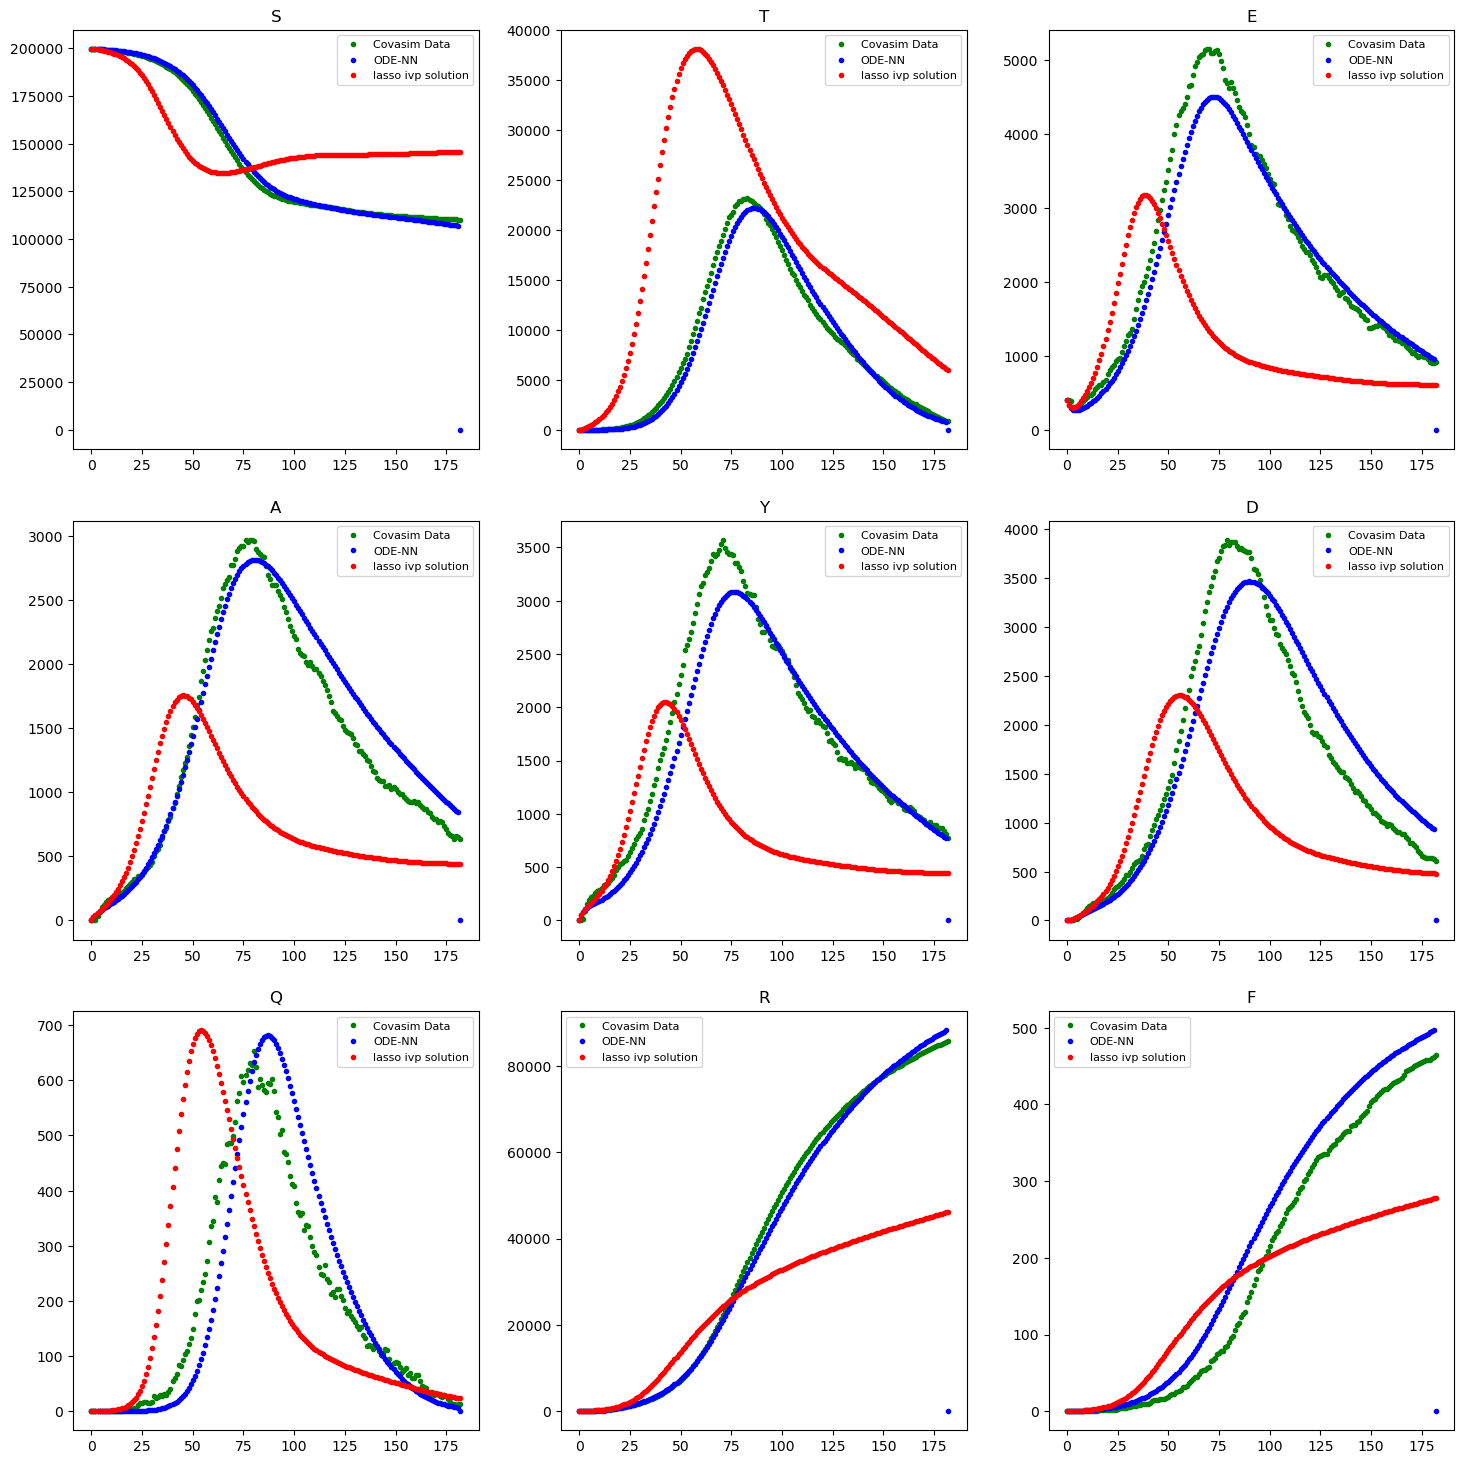

In [122]:


plot=True
if plot:
    n = data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, data[:, i - 1] * population, '.g', label='Covasim Data')
        ax.plot(t, u_sim_NN[:, i - 1] * population,'.b', label='ODE-NN')
        ax.plot(t, sol1_mat[:, i - 1] * population,'.r', label = "lasso ivp solution")
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(os.path.join(model.save_folder, case_name + '.png') )
        # plt.show()

In [151]:
sens_list = []
h = 1e-16
comp = 1e-16j #the complex number with 0 real and 1e-16 complex part

LT = lasso_tup



# To Do: What are the object types of .coef_????
# To Do: Make sure we are including the constant from Lassoing the MLPs (BIG DEAL!)
macro_coefs = [np.concatenate((macro_param.coef_, np.array([macro_param.intercept_]))) for macro_param in LT] #makes a list of the eta coefs, beta coefs, and tau coefs, does not include intercept

macro_coefs_copy = macro_coefs
for i, param_coefs in enumerate(macro_coefs): #iterates through the list of arrays, macro_coefs
    macro_coefs_copy[i] = np.array(macro_coefs[i], dtype = "complex")
    for coef_idx, coef in enumerate(param_coefs): #iterates through the array of coefficients, param_coefs
        if coef != 0:
            macro_coefs_copy[i][coef_idx] += comp
            coefs_tup = tuple(macro_coefs_copy)
            comp_args = (coefs_tup, params, time_max, chi_type)
            sol2 = solve_ivp(lasso_ODE_test, time_span, y0comp, t_eval=time_values, args=comp_args, method='RK45')
            sol2_mat = np.matrix(sol2.y).T
            sens_vals = np.imag(sol2_mat/h)
            sens_list.append(sens_vals)

print(np.max(sens_list[0]))


'''
Note of where I'm at 7/31/23 @noon

I have a list of matricies that should be the sensitivities
where each element in the list is for changing one of the coefficients values to have a little bit of complex

element 0 should be eta's first coefficient, 1 should be eta's 3rd coefficient (because the second coefficient is 0), and so on.
intercepts are included


'''
            
            
         
    


/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:113: ComplexWarning: Casting complex values to real discards the imaginary part
  S = float(S)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  T = float(T)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  E = float(E)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  A = float(A)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  Y = float(Y)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:118: ComplexWarning: Casting complex values to real

0.8001456470675519


/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:113: ComplexWarning: Casting complex values to real discards the imaginary part
  S = float(S)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  T = float(T)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  E = float(E)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  A = float(A)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  Y = float(Y)
/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_34567/3607229031.py:118: ComplexWarning: Casting complex values to real

"\nNote of where I'm at 7/31/23 @noon\n\nI have a list of matricies that (in theory) should be the sensitivities\nwhere each element in the list is for changing one of the coefficients values to have a little bit of complex\n\nelement 0 should be eta's first coefficient, 1 should be eta's 3rd coefficient (because the second coefficient is 0), and so on.\nintercepts are included\n\n\n"